# Analysis of IMB

This notebook performs data analysis of the csv files created by running the IMB benchmark

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import re

# Standardise Fonts
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8) 
plt.rc('axes', titlesize=10)
plt.rc("axes", labelsize=8)

In [2]:
MBPS = "$\mathregular{MBs^{-1}}$"
USEC = "$\mathregular{\mu sec}$"

In [3]:
results = {
    "Cloud_IMB":[],
    "SCARF_IMB":[],
    "SCARF_IMB_CPUs": [],
    "JASMIN_IMB":[],
    "JASMIN_IMB_CPUs": []
}

for dataName in results:
    with open("../" + dataName + "/out.csv", "r") as fHandle:
        reader = csv.reader(fHandle)  # create an iterator over each row
        headers = next(reader) # the headers are the first line
        latencyIndex = headers.index("Latency")  #
        bandwidthIndex = headers.index("0")  # after here, all are the bandwidths
        thisMessageSizes = [int(el) for el in headers[bandwidthIndex + 1:]]
        try:
            if messageSizes != [int(el) for el in headers[bandwidthIndex + 1:]]:
                raise ValueError("Different message sizes")
        except NameError: # if messageSizes hasn't been set yet
            messageSizes = thisMessageSizes
        for row in reader:
            thisRow = dict((header, row[index]) for index, header in enumerate(headers))
            thisRow["Bandwidths"] = [float(el) for el in row[bandwidthIndex + 1:]]
            thisRow["Max Bandwidth"] = max(thisRow["Bandwidths"])
            thisRow["Mean Bandwidths"] = sum(thisRow["Bandwidths"]) / len(thisRow["Bandwidths"])
            results[dataName].append(thisRow)
print("Message Sizes:")
print(messageSizes)
print()
for dataName in results:
    print(dataName)
    print("1st latency:        {}".format(results[dataName][0]["Latency"]))
    print("max bandwidth:      {}".format(max(test["Max Bandwidth"] for test in results[dataName])))
    print("1st bandwidths(10): {}".format(results[dataName][0]["Bandwidths"][0:10]))
    print("Headers:            {}".format(results[dataName][0].keys()))
    print()
        

Message Sizes:
[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608, 16777216]

SCARF_IMB_CPUs
1st latency:        0.35
max bandwidth:      9256.52
1st bandwidths(10): [2.75, 5.6, 11.25, 22.51, 44.09, 85.62, 92.6, 160.53, 309.41, 547.37]
Headers:            dict_keys(['Latency', 'Total Requested Memory (MB)', '8', 'Protocols Seen', '1', 'Average Memory (MB)', '2', '262144', '32768', '16', '8388608', 'Max Threads', 'Turnaround time (sec.)', '256', '16777216', 'Delta Memory (MB)', 'Max Processes', '2097152', '4096', '0', 'File Name', 'Exclusive', 'CPU time (sec.)', '512', '1048576', '16384', '524288', 'Max Bandwidth', '64', '32', '1024', 'Number of Hosts', '65536', 'Max Swap (MB)', 'CPUs', 'Host Groups', '2048', '4194304', 'Mean Bandwidths', 'Bandwidths', '8192', '131072', 'Run time (sec.)', 'Hosts Used', 'Max Memory (MB)', '128', '4'])

JASMIN_IMB
1st latency:        0.14
max bandwidth:      11469

In [4]:
import datetime

# Do cloud dates:
for result in results["Cloud_IMB"]:
    result["Date Run"] = datetime.datetime.strptime(result["File Name"], "%Y%m%d_%H%M%S.out")

# Make SCARF uppercase and map 'X-X' -> 'X'
for name in ("SCARF_IMB", "JASMIN_IMB", "SCARF_IMB_CPUs", "JASMIN_IMB_CPUs"):
    for result in results[name]:
        result["Host Groups"] = result["Host Groups"].split("-")[0]
    

['SHM', 'SHM-IBV', 'SHM-TCP']


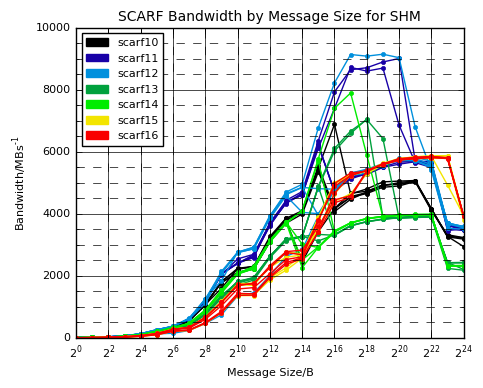

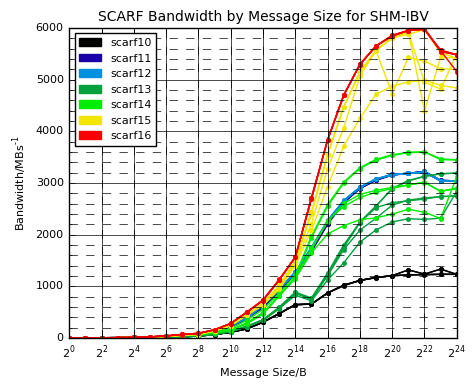

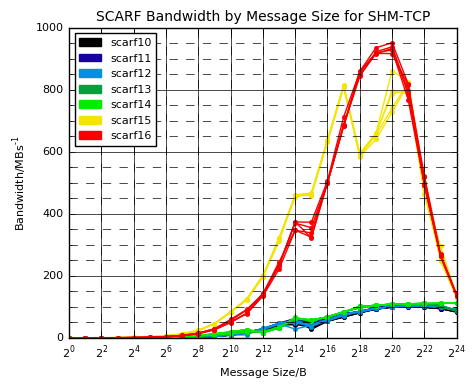

['SHM', 'SHM-TCP']


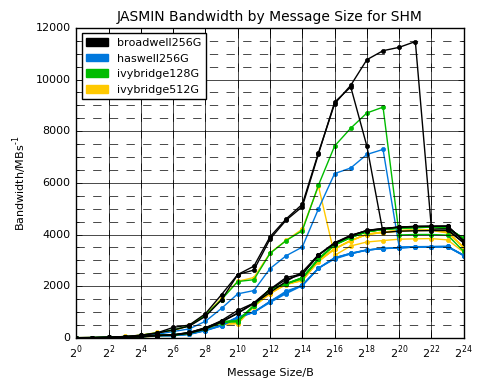

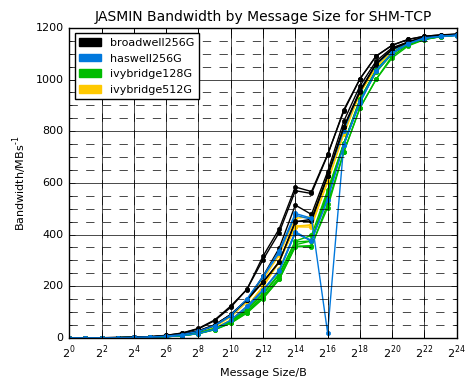

['SHM']


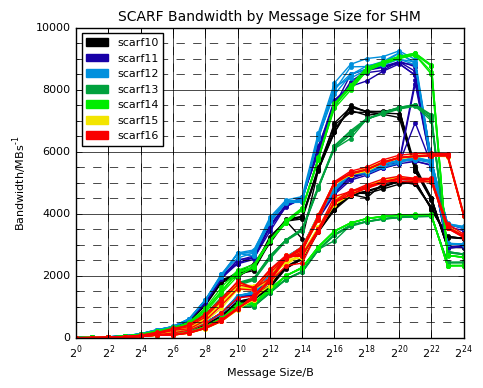

['SHM']


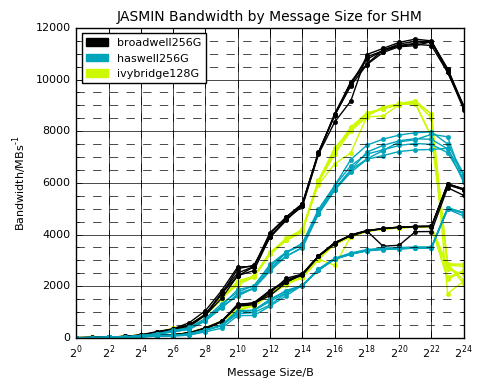

In [5]:
def plotBandwidth():
    for name in ("SCARF_IMB", "JASMIN_IMB", "SCARF_IMB_CPUs", "JASMIN_IMB_CPUs"):
        protocols = sorted(set(row["Protocols Seen"] for row in results[name]))
        print(protocols)
        for prot in protocols:
            res = [row for row in results[name] if row["Protocols Seen"] == prot]
            hostgroups = sorted(set(row["Host Groups"] for row in res))
            clrMap = plt.get_cmap("nipy_spectral")
            legendHandles = []
            plt.rcParams["figure.figsize"] = (5, 4)
            for index, hostgroup in enumerate(hostgroups):
                clr = clrMap(index / len(hostgroups))
                legendHandles.append(mpatches.Patch(color=clr, label=hostgroup))
            for index, row in enumerate(sorted(res, key=lambda el: el["File Name"])):
                band = row["Bandwidths"]
                clr = clrMap(hostgroups.index(row["Host Groups"]) / len(hostgroups))
                clr = (clr[0], clr[1], clr[2], 1)
                plt.plot(messageSizes, band, color=clr, marker=".", linestyle="-")
                nodeNumbers = ",".join(re.findall("cn\d+", row["Hosts Used"]))
                # legendHandles.append(mpatches.Patch(color=clr, label=nodeNumbers))
            plt.legend(handles=legendHandles, loc=2, ncol=1, fontsize=8)
            plt.xscale("log", basex=2)
            # plt.yscale("log")
            plt.title("{} Bandwidth by Message Size for {}".format(name.split("_")[0], prot))
            plt.xlabel("Message Size/B")
            plt.ylabel("Bandwidth/" + MBPS)
            plt.grid(True, which="minor", linestyle="--")
            plt.grid(True, which="major", linestyle="-")
            plt.minorticks_on()
            plt.show()

plotBandwidth()


['1', '2']


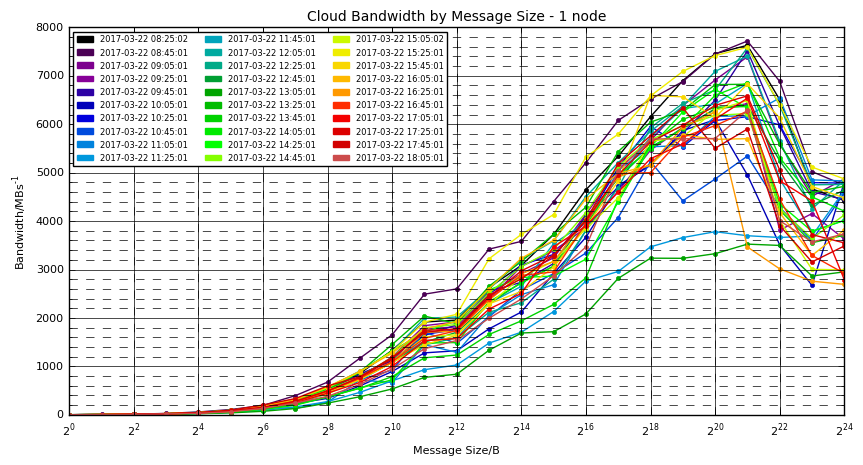

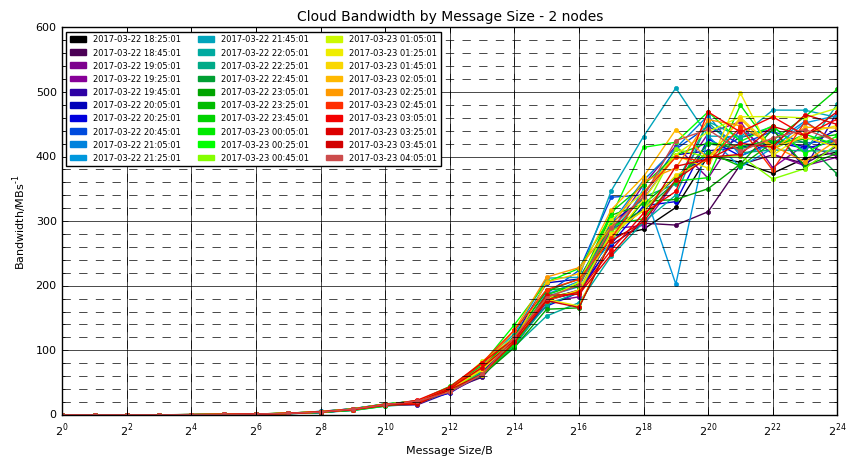

In [6]:
def plotCloudBandwidth():
    numHostsSet = sorted(set(row['Number of Hosts'] for row in results["Cloud_IMB"]))
    print(numHostsSet)
    for numHosts in numHostsSet:
        res = [row for row in results["Cloud_IMB"] if row['Number of Hosts'] == numHosts]
        clrMap = plt.get_cmap("nipy_spectral")
        legendHandles = []
        plt.rcParams["figure.figsize"] = (10, 5)
        for index, row in enumerate(sorted(res, key=lambda el: el["Date Run"])):  # sort by date run
            band = row["Bandwidths"]
            clr = clrMap(index / len(res))
            clr = (clr[0], clr[1], clr[2], 1)
            plt.plot(messageSizes, band, color=clr, marker=".", linestyle="-")
            legendHandles.append(mpatches.Patch(color=clr, label=row["Date Run"]))
        plt.legend(handles=legendHandles, loc=2, ncol=3, fontsize=6)
        plt.xscale("log", basex=2)
        titleEnd = "1 node" if numHosts == "1" else "{} nodes".format(numHosts)
        plt.title("Cloud Bandwidth by Message Size - " + titleEnd)
        plt.xlabel("Message Size/B")
        plt.ylabel("Bandwidth/" + MBPS)
        plt.grid(True, which="minor", linestyle="--")
        plt.grid(True, which="major", linestyle="-")
        plt.minorticks_on()
        plt.show()

plotCloudBandwidth()

['1', '2']


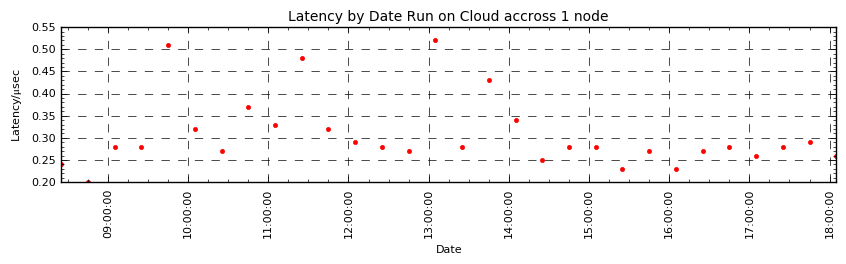

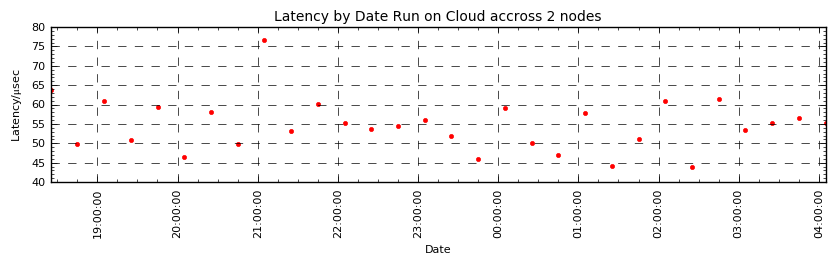

In [7]:
def plotCloudLatencies():
    numHostsSet = sorted(set(row['Number of Hosts'] for row in results["Cloud_IMB"]))
    print(numHostsSet)
    
    for index, numHosts in enumerate(numHostsSet):
        res = [row for row in results["Cloud_IMB"] if row['Number of Hosts'] == numHosts]
        plt.rcParams["figure.figsize"] = (10,2)
        plt.plot([row["Date Run"] for row in res], 
                 [row["Latency"] for row in res], "r.")
        plt.xticks(rotation='vertical')
        titleEnd = "1 node" if numHosts == "1" else "{} nodes".format(numHosts)
        plt.title("Latency by Date Run on Cloud accross " + titleEnd)
        plt.ylabel("Latency/" + USEC)
        plt.xlabel("Date")
        #plt.grid(True, which="minor", linestyle="-")
        plt.grid(True, which="major", linestyle="--")
        plt.minorticks_on()
        plt.show()

plotCloudLatencies()

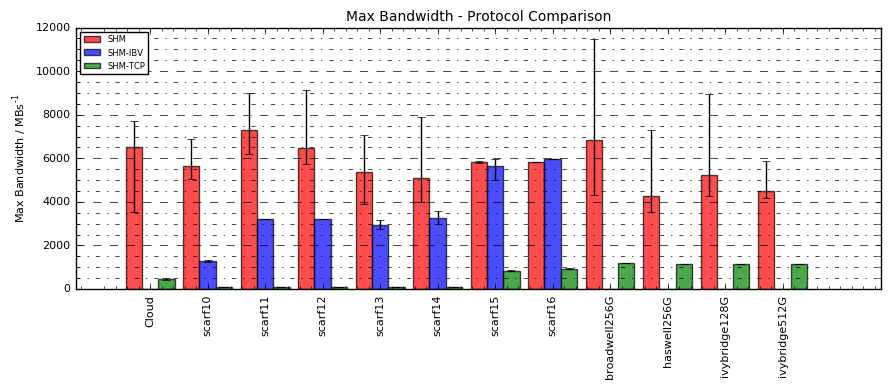

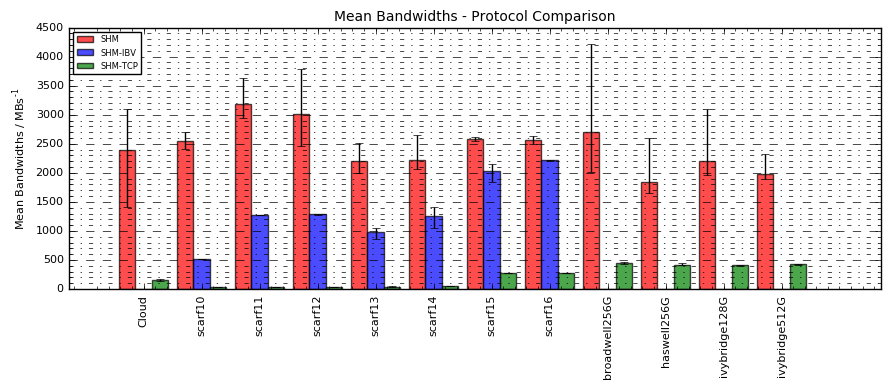

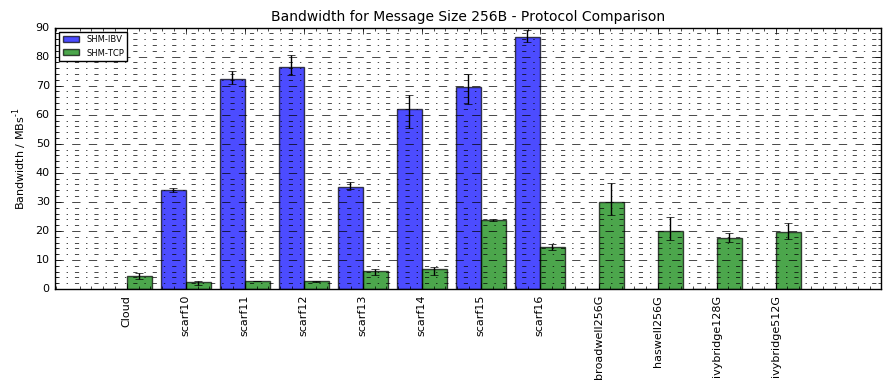

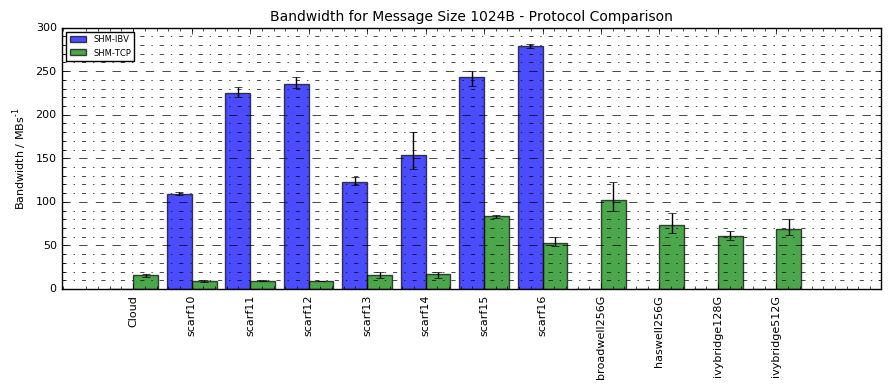

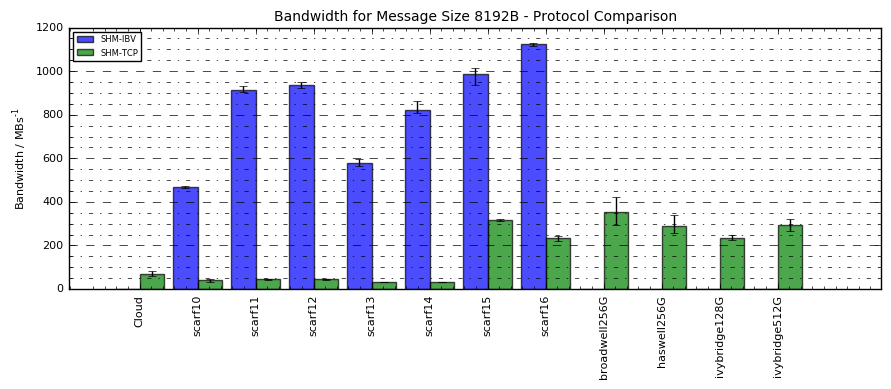

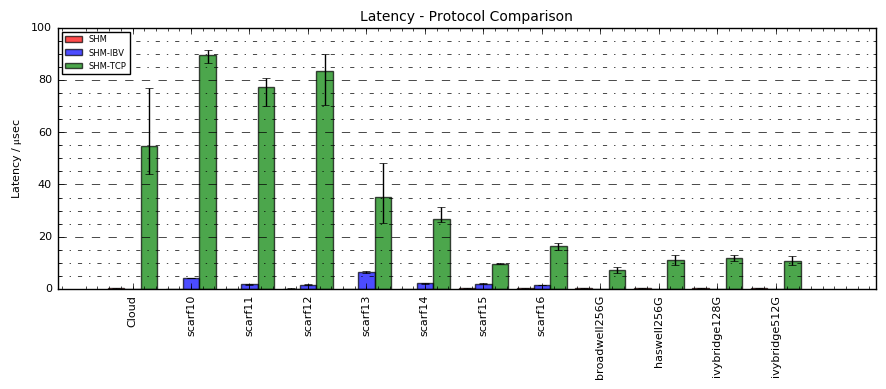

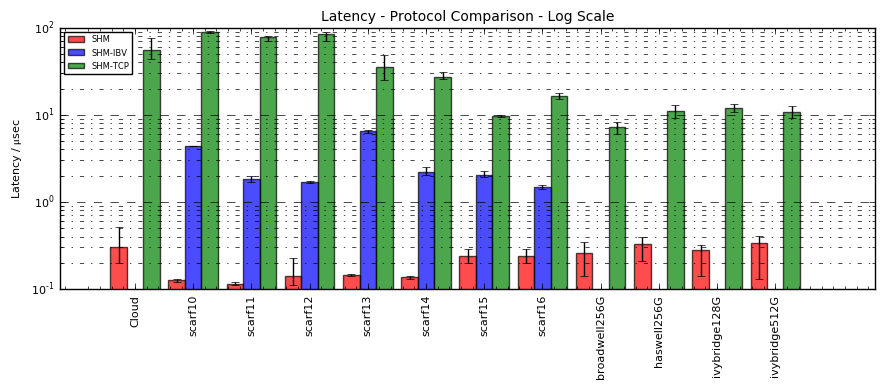

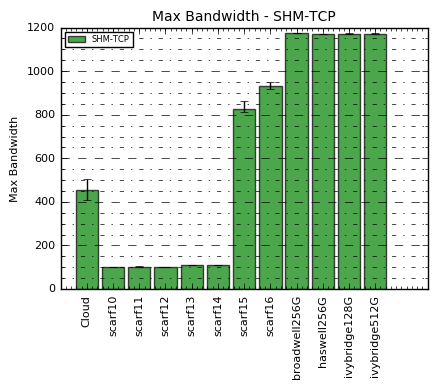

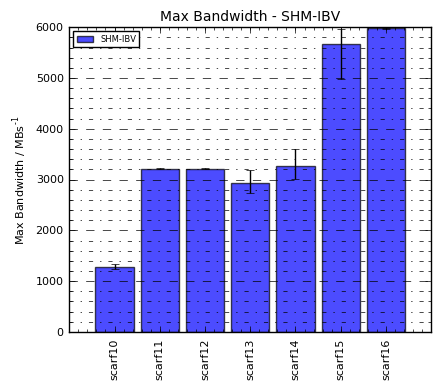

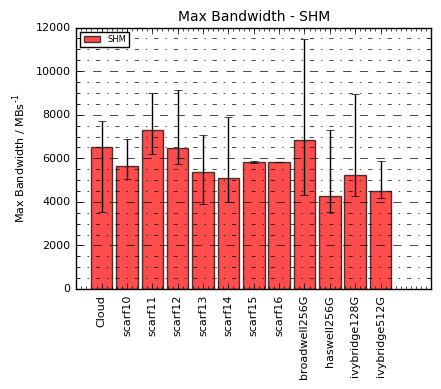

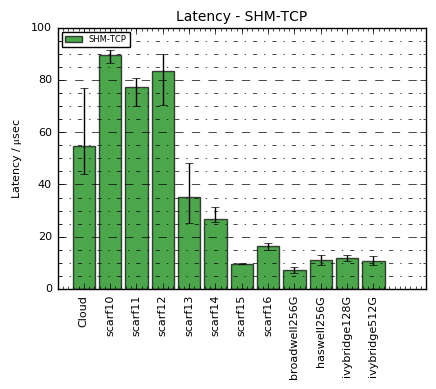

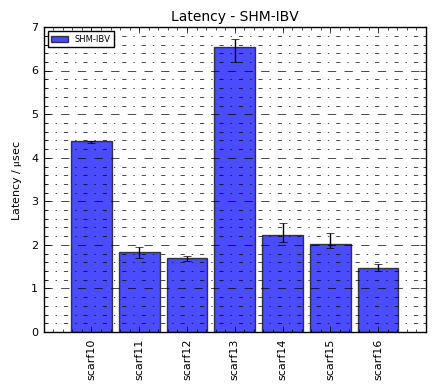

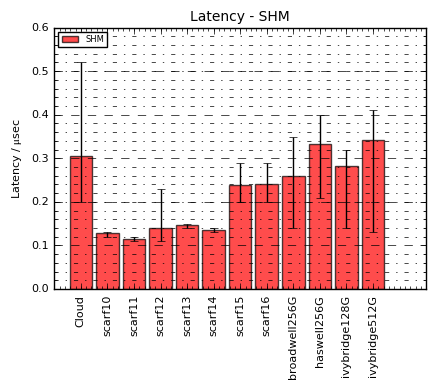

In [8]:
def plotBar(KEY, HOSTGROUPS, PROTOCOLS, UNITS=None, FIGSIZE=(4.5, 4), logY=False):
    clrs = {"SHM": "r", "SHM-TCP":"g", "SHM-IBV":"b"}
    yValues = dict((prot, []) for prot in PROTOCOLS)
    yTopError = dict((prot, []) for prot in PROTOCOLS)
    yBottomError = dict((prot, []) for prot in PROTOCOLS)
    xValues = []
    
    def addBarData(listOfBandwidths, label):
        if label in PROTOCOLS:
            listOfBandwidths = [float(val) for val in listOfBandwidths]
            nonlocal yValues
            nonlocal yTopError
            nonlocal yBottomError
            avg = sum(listOfBandwidths) / len(listOfBandwidths)
            yValues[label].append(avg)
            yTopError[label].append(max(listOfBandwidths) - avg)
            yBottomError[label].append(avg - min(listOfBandwidths))
    
    if "Cloud" in HOSTGROUPS:
        # Add the cloud split into number of hosts
        addBarData([row[KEY] for row in results["Cloud_IMB"] if row["Number of Hosts"] == "1"], "SHM")
        addBarData([row[KEY] for row in results["Cloud_IMB"] if row["Number of Hosts"] == "2"], "SHM-TCP")
        addBarData([0], "SHM-IBV")
        xValues.append("Cloud")
    
    
    # Add the SCARF and JASMIN data split into host group and number of hosts
    for name in ("SCARF_IMB", "JASMIN_IMB"):
        for hostgroup in sorted(set(row["Host Groups"] for row in results[name])):
            if hostgroup not in HOSTGROUPS:
                continue
            xValues.append(hostgroup)
            for prot in PROTOCOLS:
                thisData = [row[KEY] for row in results[name] 
                            if hostgroup in row["Host Groups"] and prot == row["Protocols Seen"]]
                if len(thisData) == 0:  # if no data then there is a divide by zero so send this (mostly IBV)
                    addBarData([0], prot)
                else:
                    addBarData(thisData, prot)
    
    index = np.arange(len(xValues)) - 1
    
    bar_width = 0.85 / len(PROTOCOLS)
    plt.rcParams["figure.figsize"] = FIGSIZE
    ax = plt.gca()
    plt.minorticks_on()
    ax.yaxis.grid(True, which='major', linestyle='--')
    ax.yaxis.grid(True, which='minor', linestyle='-.')
    
    for i, (label, yVals) in enumerate(yValues.items()):
        plt.bar(index + i * bar_width, yVals, bar_width, align='center', color=clrs[label], alpha=0.7, label=label)
        plt.errorbar(index + i * bar_width, yVals, yerr=[yBottomError[label], yTopError[label]], linestyle=" ", color="black")
    
    plt.xticks(index + ((len(PROTOCOLS) - 1) / 2) * bar_width, xValues, rotation="vertical")
    
    unitsEnd = " / " + UNITS if UNITS is not None else ""
    
    if all(i.isdigit() for i in KEY): # if the key is a natural number, make y label 'bandwidth'
        plotTitle = "Bandwidth for Message Size " + KEY + "B - "
        plt.ylabel("Bandwidth" + unitsEnd)
    else:
        # Otherwise it is 'Latency', 'Max Bandwidth' or 'Mean Bandwidth' so use the KEY itself
        plt.ylabel(KEY + unitsEnd)
        plotTitle = KEY + " - "
    if logY:
        plt.yscale("log")
    plotTitle += "Protocol Comparison" if len(PROTOCOLS) > 1 else PROTOCOLS[0]
    if logY: plotTitle += " - Log Scale" 
    plt.title(plotTitle)
    
    try:
        plt.legend(loc=2, fontsize=6)
    except IndexError:
        print(yValues.items())
        print(KEY, HOSTGROUPS, PROTOCOLS, UNITS, FIGSIZE)
    plt.tight_layout()
    
    plt.show()
    
    
hgs = set(result["Host Groups"] for name in ("SCARF_IMB", "JASMIN_IMB") for result in results[name] )
hgs.add("Cloud")

# Do bandwidths with all protocols
plotBar("Max Bandwidth", hgs, ["SHM", "SHM-TCP", "SHM-IBV"], MBPS, FIGSIZE=(9,4))
plotBar("Mean Bandwidths", hgs, ["SHM", "SHM-TCP", "SHM-IBV"], MBPS, FIGSIZE=(9,4))
plotBar("256", hgs, ["SHM-TCP", "SHM-IBV"], MBPS, FIGSIZE=(9,4))
plotBar("1024", hgs, ["SHM-TCP", "SHM-IBV"], MBPS, FIGSIZE=(9,4))
plotBar("8192", hgs, ["SHM-TCP", "SHM-IBV"], MBPS, FIGSIZE=(9,4))

# Do lactency with all protocols
plotBar("Latency", hgs, ["SHM", "SHM-TCP", "SHM-IBV"], USEC, FIGSIZE=(9,4))
plotBar("Latency", hgs, ["SHM", "SHM-TCP", "SHM-IBV"], USEC, logY=True, FIGSIZE=(9,4))


# Do bandwidths for single protocols
plotBar("Max Bandwidth", hgs, ["SHM-TCP"], )
plotBar("Max Bandwidth", [hg for hg in hgs if "scarf" in hg], ["SHM-IBV"], MBPS)
plotBar("Max Bandwidth", hgs, ["SHM"], MBPS)

# Do Latency for single protocols
plotBar("Latency", hgs, ["SHM-TCP"], USEC)
plotBar("Latency", [hg for hg in hgs if "scarf" in hg], ["SHM-IBV"], USEC )
plotBar("Latency", hgs, ["SHM"], USEC)

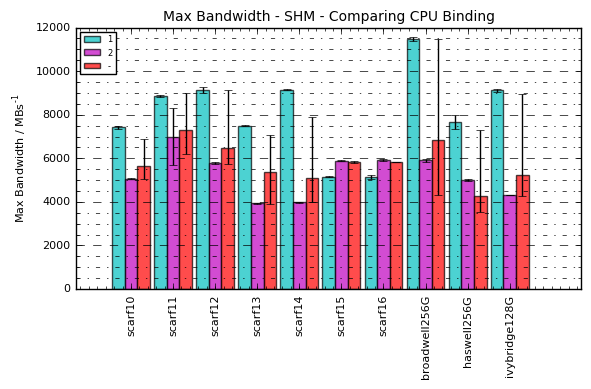

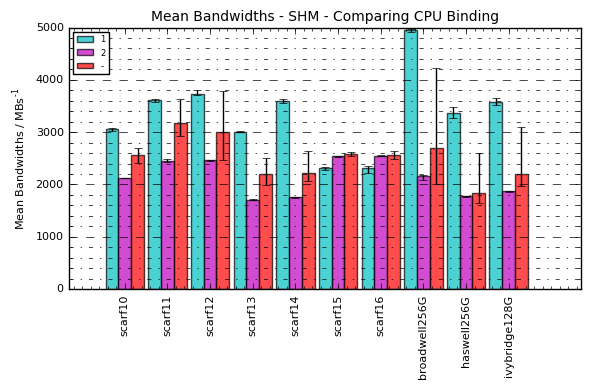

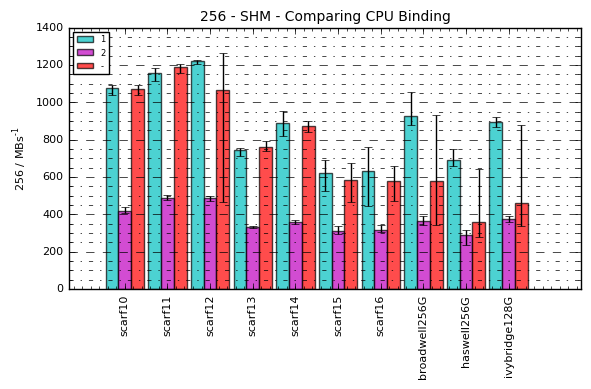

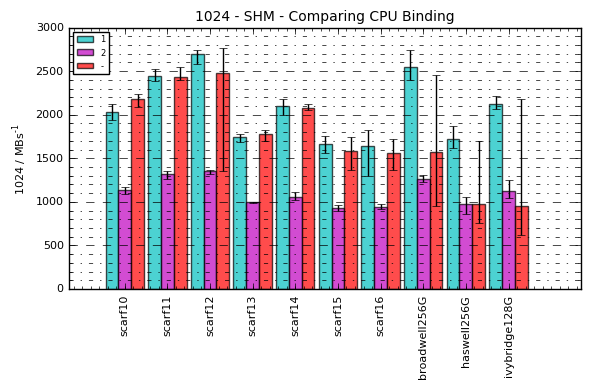

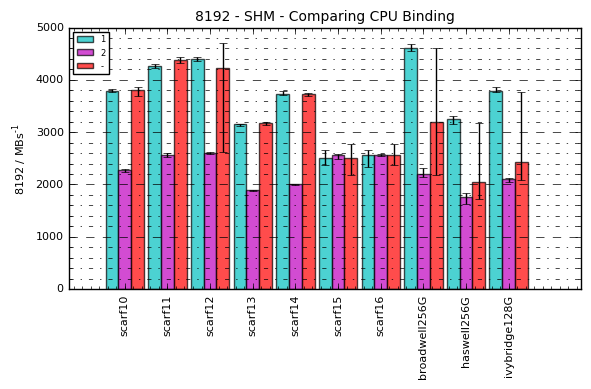

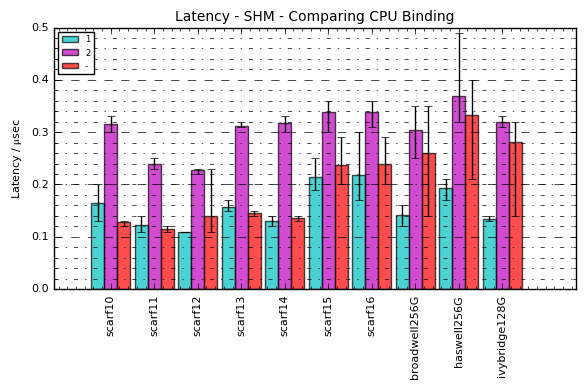

In [9]:
def plotBarCompareCPU(KEY, UNITS=None):
    CPUs = ["-","1", "2"]
    clrs = {"1":"c", "2":"m", "-":"r"}
    yValues = dict((CPU, []) for CPU in CPUs)
    yTopError = dict((CPU, []) for CPU in CPUs)
    yBottomError = dict((CPU, []) for CPU in CPUs)
    xValues = []
    
    def addBarData(listOfBandwidths, label):
        listOfBandwidths = [float(val) for val in listOfBandwidths]
        nonlocal yValues
        nonlocal yTopError
        nonlocal yBottomError
        avg = sum(listOfBandwidths) / len(listOfBandwidths)
        yValues[label].append(avg)
        yTopError[label].append(max(listOfBandwidths) - avg)
        yBottomError[label].append(avg - min(listOfBandwidths))
    
    
    
    for infra in ("SCARF", "JASMIN"):
        specificCPUs = "{}_IMB_CPUs".format(infra)
        randomCPUs = "{}_IMB".format(infra)
        # Use specific CPUs for getting the hostgroups, JASMIN has some extra hostgroups in random
        hostgroups = sorted(set(row["Host Groups"] for row in results[specificCPUs]))
        xValues += hostgroups
        for resultName in (randomCPUs, specificCPUs):
            for hostgroup in hostgroups:
                if "CPUs" in resultName:
                    # If specific CPUs, add two bars (one for each CPU setting)
                    for CPU in CPUs[1:]:
                        thisData = [row[KEY] for row in results[resultName]   
                                    if hostgroup in row["Host Groups"] and CPU == row["CPUs"]]
                        addBarData(thisData, CPU)
                else:
                    # If this isn't locked to a CPU then just add one bar under the CPU '-'
                    thisData = [row[KEY] for row in results[resultName]
                                if hostgroup in row["Host Groups"] and "SHM" == row["Protocols Seen"]]
                    addBarData(thisData, "-")
            
    
    index = np.arange(len(xValues)) - 1
    
    bar_width = 0.9 / len(CPUs)
    
    plt.rcParams["figure.figsize"] = (6,4)
    ax = plt.gca()
    plt.minorticks_on()
    ax.yaxis.grid(True, which='major', linestyle='--')
    ax.yaxis.grid(True, which='minor', linestyle='-.')
    
    for i, (label, yVals) in enumerate(yValues.items()):
        try:
            plt.bar(index + i * bar_width, yVals, bar_width, align='center', color=clrs[label], alpha=0.7, label=label)
            plt.errorbar(index + i * bar_width, yVals, yerr=[yBottomError[label], yTopError[label]], linestyle=" ", 
                         color="black")
        except ValueError:
            print(xValues, yVals)
    
    plt.xticks(index + ((len(CPUs) - 1) / 2) * bar_width, xValues, rotation="vertical")
    
    
    unitsEnd = " / " + UNITS if UNITS is not None else ""
    plt.ylabel(KEY + unitsEnd)
    # plt.yscale("log")
    plotTitle = KEY + " - SHM - Comparing CPU Binding"
    plt.title(plotTitle)

    plt.legend(loc=2, fontsize=6)
    plt.tight_layout()
    
    plt.show()

plotBarCompareCPU("Max Bandwidth", MBPS)
plotBarCompareCPU("Mean Bandwidths", MBPS)
plotBarCompareCPU("256", MBPS)
plotBarCompareCPU("1024", MBPS)
plotBarCompareCPU("8192", MBPS)
plotBarCompareCPU("Latency", USEC)